In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

# Load the dataset
imdb_data = pd.read_csv('IMDB Dataset.csv')  # Make sure the file name matches the uploaded file

# Display basic info about the dataset
print(imdb_data.shape)         # Show number of rows and columns
print(imdb_data.head(10))      # Display the first 10 rows of the dataset


Saving IMDB Dataset.csv to IMDB Dataset.csv
(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive


In [ ]:

# 1. Overview of the dataset: Summary statistics
print(imdb_data.describe())  # Will show summary statistics for numeric columns, if any.

# 2. Check for missing values and data types
print(imdb_data.info())

# 3. Check the distribution of sentiments (positive vs. negative reviews)
print(imdb_data['sentiment'].value_counts())

# 4. Check for any missing values in the dataset
print(imdb_data.isnull().sum())


                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
review       0
sentiment    0
dtype: int64


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


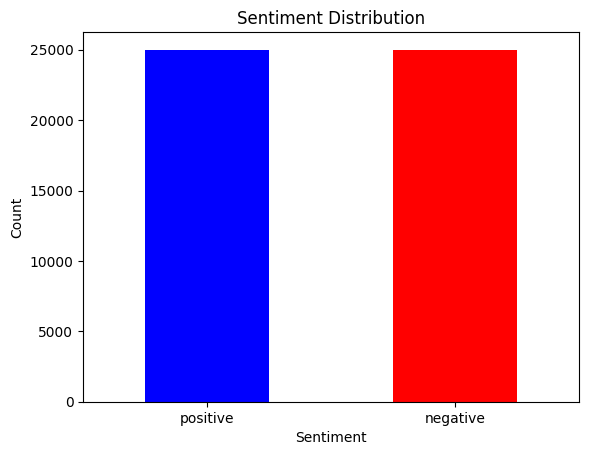

In [ ]:
# Sentiment count
sentiment_counts = imdb_data['sentiment'].value_counts()
print(sentiment_counts)

# Visualize sentiment distribution using a bar plot
sentiment_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+', ' ', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove non-alphabetical characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply the text cleaning function to the 'review' column
imdb_data['cleaned_review'] = imdb_data['review'].apply(clean_text)


In [ ]:
# Initialize the tokenizer
max_features = 10000  # Max number of words to consider
max_length = 150      # Maximum length of each review (number of words)

tokenizer = Tokenizer(num_words=max_features, lower=True, split=' ')
tokenizer.fit_on_texts(imdb_data['cleaned_review'])

# Convert the reviews to sequences of integers
X = tokenizer.texts_to_sequences(imdb_data['cleaned_review'])

# Pad sequences to ensure all have the same length
X = pad_sequences(X, padding='post', maxlen=max_length)

# Convert the 'sentiment' labels to numeric values (positive=1, negative=0)
y = imdb_data['sentiment'].map({'positive': 1, 'negative': 0}).values


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_length))  # Embedding layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)


Epoch 1/5
625/625 - 310s - 496ms/step - accuracy: 0.5447 - loss: 0.6782 - val_accuracy: 0.5872 - val_loss: 0.6494
Epoch 2/5
625/625 - 320s - 512ms/step - accuracy: 0.8038 - loss: 0.4116 - val_accuracy: 0.8838 - val_loss: 0.2815
Epoch 3/5
625/625 - 304s - 487ms/step - accuracy: 0.9144 - loss: 0.2292 - val_accuracy: 0.8924 - val_loss: 0.2687
Epoch 4/5
625/625 - 313s - 501ms/step - accuracy: 0.9407 - loss: 0.1689 - val_accuracy: 0.8878 - val_loss: 0.2779
Epoch 5/5
625/625 - 305s - 487ms/step - accuracy: 0.9585 - loss: 0.1251 - val_accuracy: 0.8855 - val_loss: 0.3348


In [ ]:
# Predict the sentiment of test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step
Accuracy: 0.8855
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4961
           1       0.89      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
[[4423  538]
 [ 607 4432]]


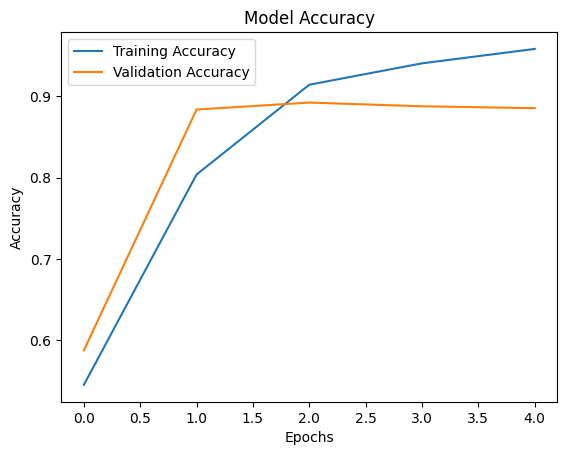

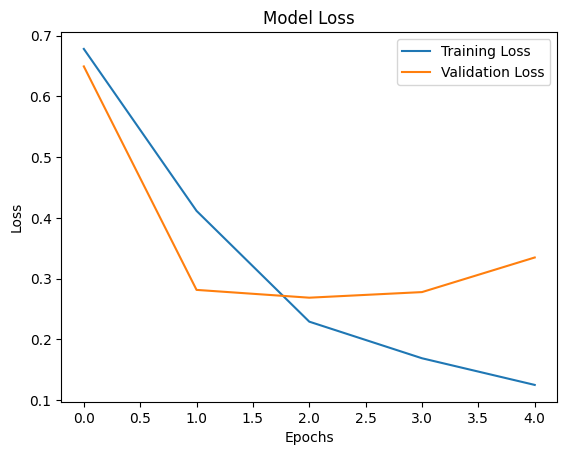

In [ ]:
# Plot the training history (accuracy and loss)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Tuning Hyperparameter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

# Hyperparameters
embedding_dim = 128
lstm_units = 128
dropout_rate = 0.2
epochs = 5
batch_size = 64

# Build the model with improved hyperparameters
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss function
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model with the scheduler
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=2)


Epoch 1/5
625/625 - 315s - 504ms/step - accuracy: 0.5268 - loss: 0.6857 - val_accuracy: 0.5138 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 2/5
625/625 - 303s - 485ms/step - accuracy: 0.6875 - loss: 0.5535 - val_accuracy: 0.8274 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 3/5
625/625 - 326s - 522ms/step - accuracy: 0.8682 - loss: 0.3365 - val_accuracy: 0.8709 - val_loss: 0.3317 - learning_rate: 0.0010
Epoch 4/5
625/625 - 323s - 516ms/step - accuracy: 0.9044 - loss: 0.2575 - val_accuracy: 0.8779 - val_loss: 0.3169 - learning_rate: 0.0010
Epoch 5/5
625/625 - 325s - 521ms/step - accuracy: 0.9213 - loss: 0.2139 - val_accuracy: 0.8811 - val_loss: 0.2988 - learning_rate: 0.0010


In [ ]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Load IMDB dataset
max_features = 20000  # Top 20,000 words to consider
maxlen = 500  # Maximum length of each review (in words)

# Load and prepare the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to ensure uniform input size
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Build the BiLSTM model
model = Sequential()

# Add an embedding layer to map word indices to word vectors
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=maxlen))

# Add the Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

# Add a fully connected layer with one output neuron for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and an Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
score, accuracy = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Accuracy: {accuracy:.4f}")

# Optionally: Predict on a sample
sample_review = x_test[0]
predicted_sentiment = model.predict(np.array([sample_review]))
print(f"Predicted sentiment (1=positive, 0=negative): {predicted_sentiment[0][0]:.4f}")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1537s 4s/step - accuracy: 0.6881 - loss: 0.5670 - val_accuracy: 0.8428 - val_loss: 0.3780
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1574s 4s/step - accuracy: 0.8641 - loss: 0.3324 - val_accuracy: 0.8447 - val_loss: 0.3809
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1499s 4s/step - accuracy: 0.8854 - loss: 0.2807 - val_accuracy: 0.8518 - val_loss: 0.3675
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1523s 4s/step - accuracy: 0.9152 - loss: 0.2235 - val_accuracy: 0.8565 - val_loss: 0.3674
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1503s 4s/step - accuracy: 0.9223 - loss: 0.2030 - val_accuracy: 0.8522 - val_loss: 0.3842
391/391 ━━━━━━━━━━━━━━━━━━━━ 212s 543ms/step - accuracy: 0.8525 - loss: 0.3861
Test Accuracy: 0.8522
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted sentiment (1=positive, 0=negative): 0.7302
